In [2]:
#We load in the specific data needed
import polars as pl
import numpy as np
import os
from pathlib import Path
import pandas as pd
from datetime import date
import datetime
import hvplot.polars
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.interpolate import bisplrep, bisplev
from datetime import timedelta
from patsy import dmatrix
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score

# data = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_train_tech_nonscaled.parquet')
# datat = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_test_tech_nonscaled.parquet')

# prc_filter = 0.125

# data = data[data['prc_option'] > prc_filter]
# datat = datat[datat['prc_option'] > prc_filter]

data = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_train_val_tech_standardized_filter.parquet')
datat = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_test_tech_scaled_all_sso_filter.parquet')

impl_volatility = 'impl_volatility_h_1_step'

test_data = datat[datat['date'] >= '2021-01-01']
total_train = data[data['date'] < '2021-01-01']

# data_sso = data_sso[data_sso['prc_option'] > prc_filter]
# datat_sso = datat_sso[datat_sso['prc_option'] > prc_filter]

# basic = ['moneyness', 'T', 'moneyness_squared', 'tau_squared', 'moneyness_tau']
basic = ['moneyness', 'T']
option_specific = ['cp_flag', 'spread_option', 'volume', 'prc_option', 'previous_iv']
macro_features = ['1Y_bond','2Y_bond','FF_rate', 'gold_price','reces_indi','10Y_RIR', 'CLOSE_vix', 'hi-lo_vix']
stock_specific = ['BID', 'ASK', 'daily_return_indicator_stock', 'hi-lo_stock', 'PRC', "vol_stock", 'RET', 'spread_stock']

tickers = ['ticker_AAPL', 'ticker_AMZN', 'ticker_META', 'ticker_MSFT','ticker_NVDA', 'ticker_TSLA'  ]


totalList = ['moneyness', 'T'] + macro_features + option_specific + stock_specific + tickers

totalList = ['T',
 'moneyness',
 'previous_iv',
 'spread_option',
 '2Y_bond',
 'RET',
 'cp_flag',
 'ticker_TSLA',
 'ticker_AMZN']

#  'ticker_MSFT',
#  'ticker_AAPL',
#  'ticker_NVDA',
#  'ticker_META']
totalList_standardize = totalList + ['impl_volatility', 'date', 'ticker']

In [3]:
data

,date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,...,ticker_MSFT,ticker_NVDA,ticker_TSLA,Ticker,impl_volatility_h_1_step,impl_volatility_h_5_step,dollar_volume,total_iv_weighted,previous_iv,previous_iv_all
421,2019-01-02,1,0.224218,-0.470324,-0.468200,-0.329434,-0.384042,0.559793,0.012080,-0.478085,...,0,0,0,AMZN,1.445527,0.643147,-0.238959,-0.175597,-0.056179,-0.283184
422,2019-01-02,1,0.195566,-0.461663,-0.463541,-0.327707,-0.372108,0.507672,0.033609,-0.462784,...,0,0,0,AMZN,1.204495,0.546600,-0.238859,-0.175542,-0.056179,-0.283184
423,2019-01-02,1,0.197954,-0.457766,-0.463964,-0.326269,-0.335037,0.523699,0.036926,-0.461884,...,0,0,0,AMZN,1.224912,0.552881,-0.238776,-0.175491,-0.056179,-0.283184
424,2019-01-02,1,0.200342,-0.469458,-0.463541,-0.329290,-0.373378,0.503224,0.022960,-0.468995,...,0,0,0,AMZN,1.245268,0.559628,-0.238943,-0.175590,-0.056179,-0.283184
425,2019-01-02,1,0.035593,1.431971,1.484853,0.127964,0.013337,0.436638,2.174139,-0.237812,...,0,0,0,AMZN,0.530190,0.399060,2.214955,1.025472,-0.056179,-0.283184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173367,2020-12-31,0,1.792907,3.902399,3.905520,-0.315334,-0.358905,0.258224,-2.053130,-0.378718,...,0,0,0,AMZN,0.356984,0.265274,-0.050959,-0.121191,-0.860331,-0.524777
173368,2020-12-31,0,1.788132,3.746509,3.748802,-0.329434,-0.376171,0.258676,-2.016479,-0.375973,...,0,0,0,AMZN,0.355609,0.265490,-0.222204,-0.170750,-0.860331,-0.524777
173369,2020-12-31,0,1.783356,3.573298,3.577258,-0.325837,-0.358651,0.256440,-1.984904,-0.372507,...,0,0,0,AMZN,0.355770,0.265789,-0.182627,-0.159416,-0.860331,-0.524777
173370,2020-12-31,0,1.778581,3.423903,3.422658,-0.326700,-0.306090,0.256743,-1.946709,-0.369897,...,0,0,0,AMZN,0.353283,0.266182,-0.194042,-0.162682,-0.860331,-0.524777


In [4]:
totalList

['T',
 'moneyness',
 'previous_iv',
 'spread_option',
 '2Y_bond',
 'RET',
 'cp_flag',
 'ticker_TSLA',
 'ticker_AMZN']

In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

def newey_west_standard_error(errors, lag=1):
    """
    Computes the Newey-West standard error for the series of prediction errors.
    
    Parameters:
    - errors: Array-like of prediction errors
    - lag: Maximum lag to use for the Newey-West estimator (default is 1)
    
    Returns:
    - Newey-West standard error of the prediction errors
    """
    X = np.ones(len(errors))  # Constant term for OLS
    ols_model = sm.OLS(errors, X).fit(cov_type='HAC', cov_kwds={'maxlags': lag})
    return ols_model.bse[0]  # Standard error of the constant term

def plot_real_vs_predicted(test_data, real_values, predicted_values, title):
    """
    Plot Real vs Predicted Implied Volatility over time.
    """
    plt.figure(figsize=(12, 6))
    plt.scatter(test_data['date'], real_values, label='Real Implied Volatility', color='blue', alpha=0.6)
    plt.scatter(test_data['date'], predicted_values, label='Predicted Implied Volatility', color='red', alpha=0.6)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Implied Volatility', fontsize=14)
    plt.title(f'Real vs Predicted Implied Volatility Over Time ({title})', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()

def predict_test_data_by_groups_glm(IV, test_data, model, totalList, ticker_groups):
    """
    Predict the target variable for test data by groups and calculate metrics (RMSE, R², Newey-West).

    Parameters:
    IV (str): Name of the target variable.
    test_data (pd.DataFrame): Test dataset.
    model: Trained GLM model.
    totalList (list): List of features used in the GLM.
    ticker_groups (list): List of ticker groups (each group can be a list of tickers or a single ticker).

    Returns:
    dict: Results for each group, including metrics and saved Newey-West statistics.
    """
    group_results = {}

    for group_idx, group in enumerate(ticker_groups):
        tickers = [group] if isinstance(group, str) else group
        group_data = test_data[test_data['Ticker'].isin(tickers)]

        combined_actual, combined_predicted = [], []

        for ticker in tickers:
            ticker_data = group_data[group_data['Ticker'] == ticker]
            y_actual = ticker_data[IV]
            X = ticker_data[totalList].copy()

            # Add squared terms for GLM
            for feature in totalList:
                X[f"{feature}_squared"] = X[feature] ** 2

            # Add constant term
            X = sm.add_constant(X, has_constant='add')

            # Predict for the ticker
            y_pred = model.predict(X)
            combined_actual.extend(y_actual)
            combined_predicted.extend(y_pred)

        # Convert to numpy arrays for metrics calculation
        combined_actual = np.array(combined_actual)
        combined_predicted = np.array(combined_predicted)

        # Calculate RMSE and R² for the group
        group_rmse = np.sqrt(mean_squared_error(combined_actual, combined_predicted))
        group_r2 = r2_score(combined_actual, combined_predicted)

        # Calculate Newey-West standard error
        errors = combined_actual - combined_predicted
        group_data['Errors'] = errors

        if 'date' in group_data.columns:
            daily_avg_errors = group_data.groupby('date')['Errors'].mean()
            nw_std_error = newey_west_standard_error(daily_avg_errors.values, lag=1)
        else:
            raise ValueError("The dataset does not contain a 'date' column.")

        # Save results to CSV
        group_name = "_".join(tickers)
        file_path = f'/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Notebooks/Notebook_modeling/db_performance_evaluation/glm_{group_name}.csv'
        results_df = pd.DataFrame({
            'Date': daily_avg_errors.index,
            'Daily Avg Errors': daily_avg_errors.values,
            'Newey-West Std Error': [nw_std_error] * len(daily_avg_errors)
        })
        results_df.to_csv(file_path, index=False)
        print(f"Newey-West results saved to {file_path}")

        # Store metrics in the results dictionary
        group_results[f'Group {group_idx + 1}'] = {
            'Group_Tickers': tickers,
            'Group_RMSE': group_rmse,
            'Group_R²': group_r2,
            'Newey-West Std Error': nw_std_error
        }

    return group_results

# Example usage
ticker_groups = ['AMZN', 'TSLA', ['META', 'MSFT', 'NVDA', 'AAPL']]

# Prepare training data for GLM
y_train = data[impl_volatility]
X_train = data[totalList].copy()

# Add squared terms for GLM
for feature in totalList:
    X_train[f"{feature}_squared"] = X_train[feature] ** 2

# Add constant term
X_train = sm.add_constant(X_train, has_constant='add')

# Train GLM model
model_glm = sm.GLM(y_train, X_train, family=sm.families.Gaussian()).fit()

# Predict and calculate metrics by group
results_glm = predict_test_data_by_groups_glm(
    IV=impl_volatility,
    test_data=datat,
    model=model_glm,
    totalList=totalList,
    ticker_groups=ticker_groups
)

# Print group-specific results
for group_name, group_result in results_glm.items():
    print(f"{group_name}:")
    for metric_name, value in group_result.items():
        print(f"  {metric_name}: {value}")


Newey-West results saved to /Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Notebooks/Notebook_modeling/db_performance_evaluation/glm_AMZN.csv
Newey-West results saved to /Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Notebooks/Notebook_modeling/db_performance_evaluation/glm_TSLA.csv
Newey-West results saved to /Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Notebooks/Notebook_modeling/db_performance_evaluation/glm_META_MSFT_NVDA_AAPL.csv
Group 1:
  Group_Tickers: ['AMZN']
  Group_RMSE: 0.17509577405088386
  Group_R²: 0.5166100065159562
  Newey-West Std Error: 0.006910179492494339
Group 2:
  Group_Tickers: ['TSLA']
  Group_RMSE: 0.2622198699812096
  Group_R²: 0.6379501773330241
  Newey-West Std Error: 0.010387537670695713
Group 3:
  Group_Tickers: ['META', 'MSFT', 'NVDA', 'AAPL']
  Group_RMSE: 0.18506495063133885
  Group_R²: 0.5535151442761146
  Newey-West Std Error: 0.00491816810116055


/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_15301/294646917.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_data['Errors'] = errors
/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_15301/294646917.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_data['Errors'] = errors
/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_15301/294646917.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [6]:
feature_names

NameError: name 'feature_names' is not defined

In [17]:
index_features_list = top_10_features.index.to_list()
values_list = top_10_features.values.tolist()
print(values_list)


[0.3224149854844788, 0.10646777244407703, 0.10046524387711019, 0.100465243877109, 0.09571069965641367, 0.07654776137377534, 0.04680380928692877, 0.03616627131461661, 0.022405670746750043, 0.022405670746745474]


Calculating feature importance for group: Group 1 (AMZN)
Baseline R² (OOS) for Group 1 (AMZN): 0.5166
Feature: T, Baseline R²: 0.5166, Perturbed R²: 0.3511, Absolute Change: 0.1655
Feature: moneyness, Baseline R²: 0.5166, Perturbed R²: 0.1357, Absolute Change: 0.3809
Feature: previous_iv, Baseline R²: 0.5166, Perturbed R²: 0.0474, Absolute Change: 0.4692
Feature: spread_option, Baseline R²: 0.5166, Perturbed R²: 0.5000, Absolute Change: 0.0166
Feature: 2Y_bond, Baseline R²: 0.5166, Perturbed R²: 0.5236, Absolute Change: 0.0070
Feature: RET, Baseline R²: 0.5166, Perturbed R²: 0.5181, Absolute Change: 0.0015
Feature: cp_flag, Baseline R²: 0.5166, Perturbed R²: 0.5096, Absolute Change: 0.0070
Feature: ticker_TSLA, Baseline R²: 0.5166, Perturbed R²: 0.5166, Absolute Change: 0.0000
Feature: ticker_AMZN, Baseline R²: 0.5166, Perturbed R²: 0.5239, Absolute Change: 0.0073
Calculating feature importance for group: Group 2 (TSLA)
Baseline R² (OOS) for Group 2 (TSLA): 0.6380
Feature: T, Baseline 

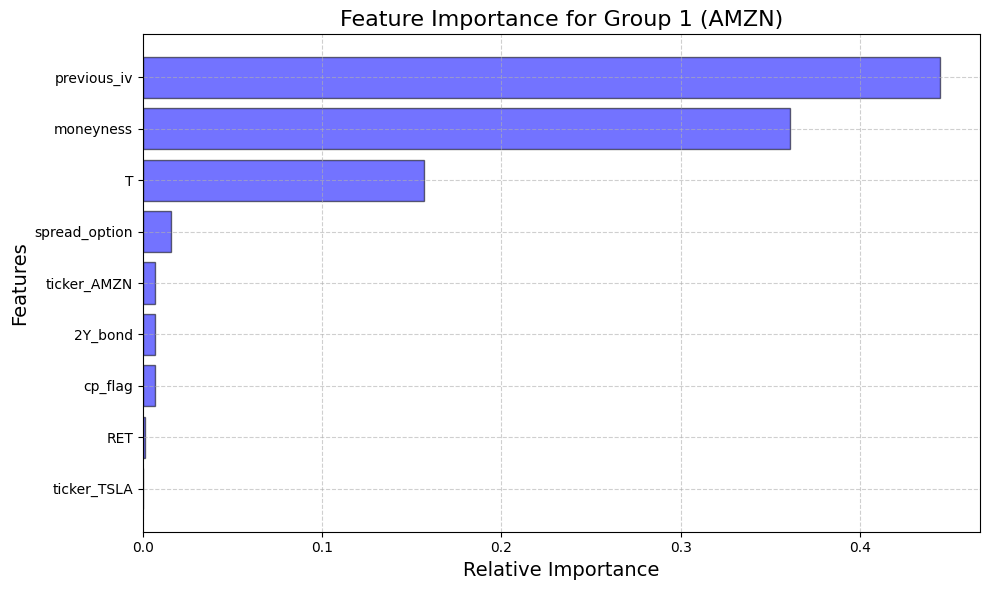

Baseline R² for Group 2 (TSLA): 0.6380


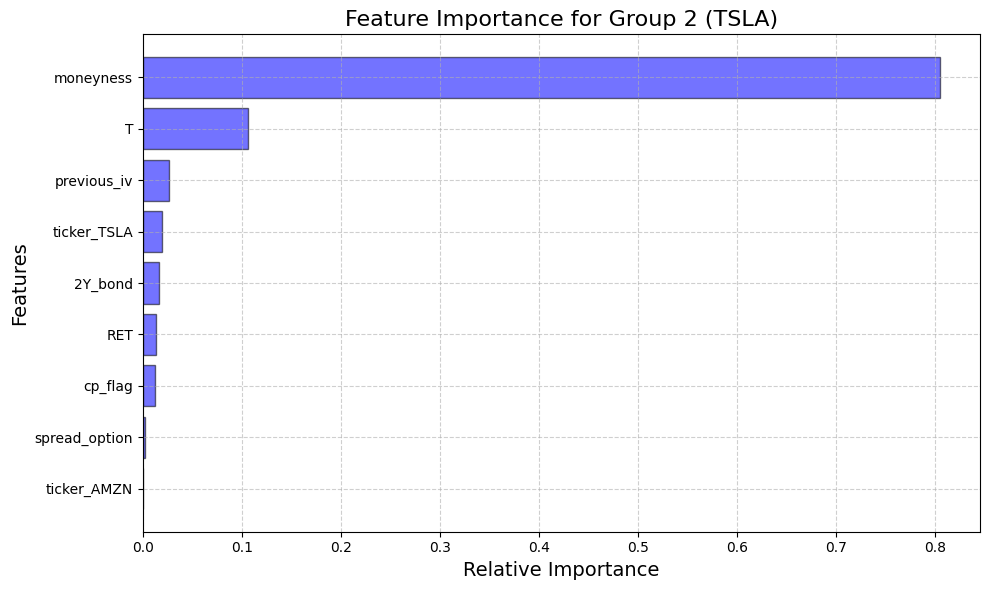

Baseline R² for Group 3 (META, MSFT, NVDA, AAPL): 0.5535


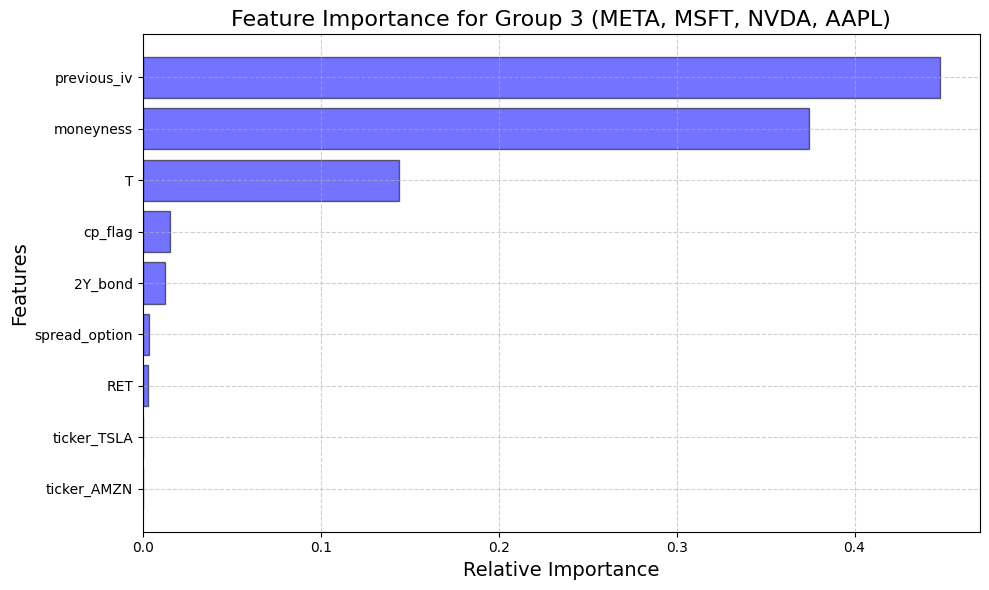

Group 1 ENet Importance (AMZN) in correct order: [0.156880102179564, 0.3610180679135576, 0.4447734467196797, 0.0, 0.0066022732125321235, 0.006634631643179253, 0.006950885980494103, 0.0014009157202330346, 0.015739676630760254]
Group 2 ENet Importance (TSLA) in correct order: [0.10611065996755498, 0.8055485013403413, 0.02618296184111921, 0.019019307266414466, 0.012319063003043843, 0.015990702102729328, 0.0, 0.013038912120459122, 0.0017898923583377845]
Group 3 ENet Importance (META, MSFT, NVDA, AAPL) in correct order: [0.14376025902431186, 0.374238665143925, 0.44811040979664757, 0.0, 0.015322498474274894, 0.012257674639788283, 0.0, 0.0030540348143818343, 0.0032564581066705455]


In [7]:
def calculate_feature_importance_r2_glm_grouped(data_test, features, target, model, ticker_groups):
    """
    Calculate feature importance for GLM for each group of tickers based on the absolute change in R²_oos.

    Parameters:
    - data_test: Test dataset
    - features: List of feature names.
    - target: Target variable (e.g., implied volatility).
    - model: Trained GLM model.
    - ticker_groups: Dictionary of groups where keys are group names and values are lists of tickers.

    Returns:
    - group_importance_results: Dictionary of feature importance DataFrames for each group.
    """
    group_importance_results = {}

    for group_name, tickers in ticker_groups.items():
        print(f"Calculating feature importance for group: {group_name}")
        
        # Filter the test dataset for the current group
        group_data = data_test[data_test['Ticker'].isin(tickers)]

        # Prepare the test dataset with squared terms
        X_test = group_data[features].copy()
        for feature in features:
            X_test[f"{feature}_squared"] = X_test[feature] ** 2

        y_test = group_data[target]

        # Add a constant term
        X_test = sm.add_constant(X_test, has_constant='add')

        # Ensure the columns in X_test match model.params
        if set(X_test.columns) != set(model.model.exog_names):
            missing_cols = set(model.model.exog_names) - set(X_test.columns)
            extra_cols = set(X_test.columns) - set(model.model.exog_names)

            # Add missing columns with zeros
            for col in missing_cols:
                X_test[col] = 0

            # Remove extra columns
            X_test = X_test[model.model.exog_names]

        # Predict on the test data and calculate baseline R²_oos
        y_test_pred = model.predict(X_test)
        baseline_r2 = r2_score(y_test, y_test_pred)
        print(f"Baseline R² (OOS) for {group_name}: {baseline_r2:.4f}")

        # Calculate the absolute change in R²_oos for each feature
        r2_changes = []
        for feature in features:
            X_test_zeroed = X_test.copy()
            if feature in X_test_zeroed.columns:
                X_test_zeroed[feature] = 0
                X_test_zeroed[f"{feature}_squared"] = 0

            y_test_pred_zeroed = model.predict(X_test_zeroed)
            r2_zeroed = r2_score(y_test, y_test_pred_zeroed)
            r2_change = abs(baseline_r2 - r2_zeroed)
            r2_changes.append(r2_change)

            print(f"Feature: {feature}, Baseline R²: {baseline_r2:.4f}, Perturbed R²: {r2_zeroed:.4f}, Absolute Change: {r2_change:.4f}")

        # Normalize the importance scores
        r2_importance = np.array(r2_changes)
        if r2_importance.sum() > 0:
            r2_importance = r2_importance / r2_importance.sum()
        else:
            r2_importance = np.zeros_like(r2_importance)

        importance_df = pd.DataFrame({
            'Feature': features,
            'Importance': r2_importance
        }).sort_values(by='Importance', ascending=False)

        group_importance_results[group_name] = {
            'Feature Importance': importance_df,
            'Baseline R²': baseline_r2
        }

    return group_importance_results


def plot_feature_importance(importance_df, title="Feature Importance"):
    """
    Plot feature importance as a bar chart.
    """
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='blue', edgecolor='black', alpha=0.55)
    plt.xlabel('Relative Importance', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    plt.title(title, fontsize=16)
    plt.gca().invert_yaxis()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Example usage
# Define groups of tickers
ticker_groups = {
    "Group 1 (AMZN)": ["AMZN"],
    "Group 2 (TSLA)": ["TSLA"],
    "Group 3 (META, MSFT, NVDA, AAPL)": ["META", "MSFT", "NVDA", "AAPL"]
}

# Calculate feature importance for each group
group_importance_results = calculate_feature_importance_r2_glm_grouped(
    data_test=datat,
    features=totalList,
    target=impl_volatility,
    model=model_glm,
    ticker_groups=ticker_groups
)

# Plot feature importance for each group
for group_name, results in group_importance_results.items():
    print(f"Baseline R² for {group_name}: {results['Baseline R²']:.4f}")
    plot_feature_importance(results['Feature Importance'], title=f"Feature Importance for {group_name}")


# Define the correct feature order
correct_order = [
    'T',
    'moneyness',
    'previous_iv',
    'ticker_TSLA',
    'cp_flag',
    '2Y_bond',
    'ticker_AMZN',
    'RET',
    'spread_option'
]

# Initialize lists to store feature importance values for each group
group1_importance_enet = []
group2_importance_enet = []
group3_importance_enet = []

# Extract and reorder the feature importance values for each group
for group_name, results in group_importance_results.items():
    importance_df = results['Feature Importance']
    # Reorder the importance values to match the correct order
    importance_dict = dict(zip(importance_df['Feature'], importance_df['Importance']))
    reordered_importance = [importance_dict.get(feature, 0) for feature in correct_order]
    if group_name == "Group 1 (AMZN)":
        group1_importance_enet = reordered_importance
    elif group_name == "Group 2 (TSLA)":
        group2_importance_enet = reordered_importance
    elif group_name == "Group 3 (META, MSFT, NVDA, AAPL)":
        group3_importance_enet = reordered_importance

# Output the lists for verification
print("Group 1 ENet Importance (AMZN) in correct order:", group1_importance_enet)
print("Group 2 ENet Importance (TSLA) in correct order:", group2_importance_enet)
print("Group 3 ENet Importance (META, MSFT, NVDA, AAPL) in correct order:", group3_importance_enet)


In [20]:
feature_importance_glm["Importance"].tolist()
# feature_importance_glm["Feature"].tolist()

[0.5386386932359339,
 0.2828763563080865,
 0.1347681937209622,
 0.011459856750237156,
 0.01063470754519592,
 0.007442086896518986,
 0.006295547466856907,
 0.005051365988735482,
 0.002833192087472933]

In [ ]:
results_list_sso

[{'Ticker': 'AMZN', 'RMSE': 0.2215907923964439, 'R²': 0.42963391007075247},
 {'Ticker': 'AAPL', 'RMSE': 0.23181520860858362, 'R²': 0.5145893824932946},
 {'Ticker': 'NVDA', 'RMSE': 0.2833792843609984, 'R²': 0.45111591740719437},
 {'Ticker': 'TSLA', 'RMSE': 0.28356663922953634, 'R²': 0.6149205101171088},
 {'Ticker': 'META', 'RMSE': 0.22937936599553427, 'R²': 0.5593223336577444},
 {'Ticker': 'MSFT', 'RMSE': 0.20558987664839676, 'R²': 0.5749042991431725}]

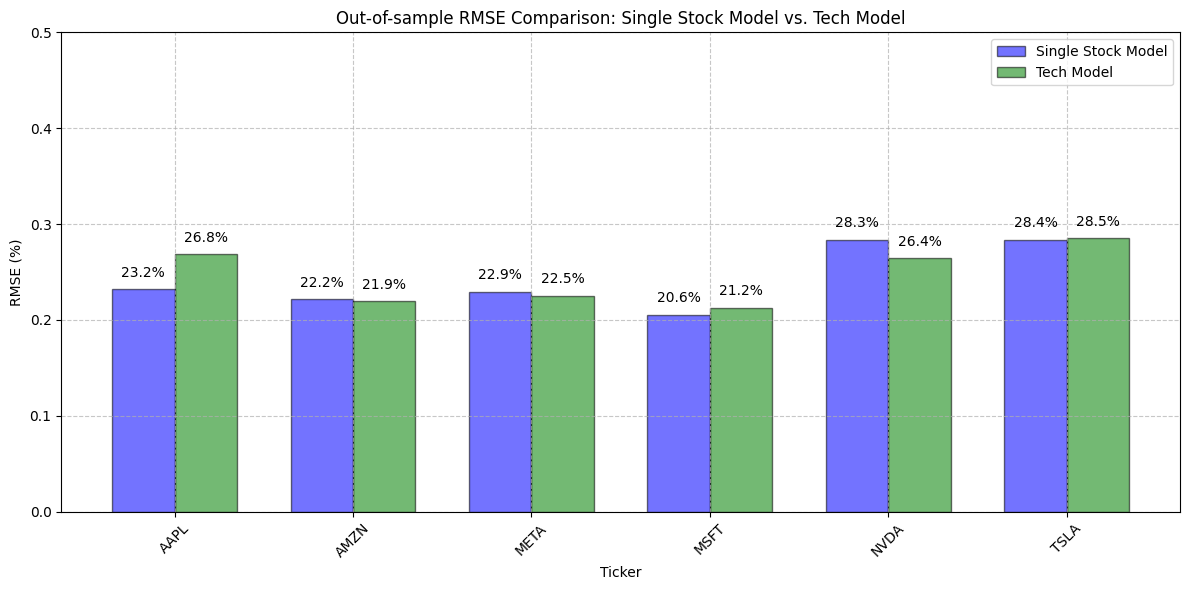

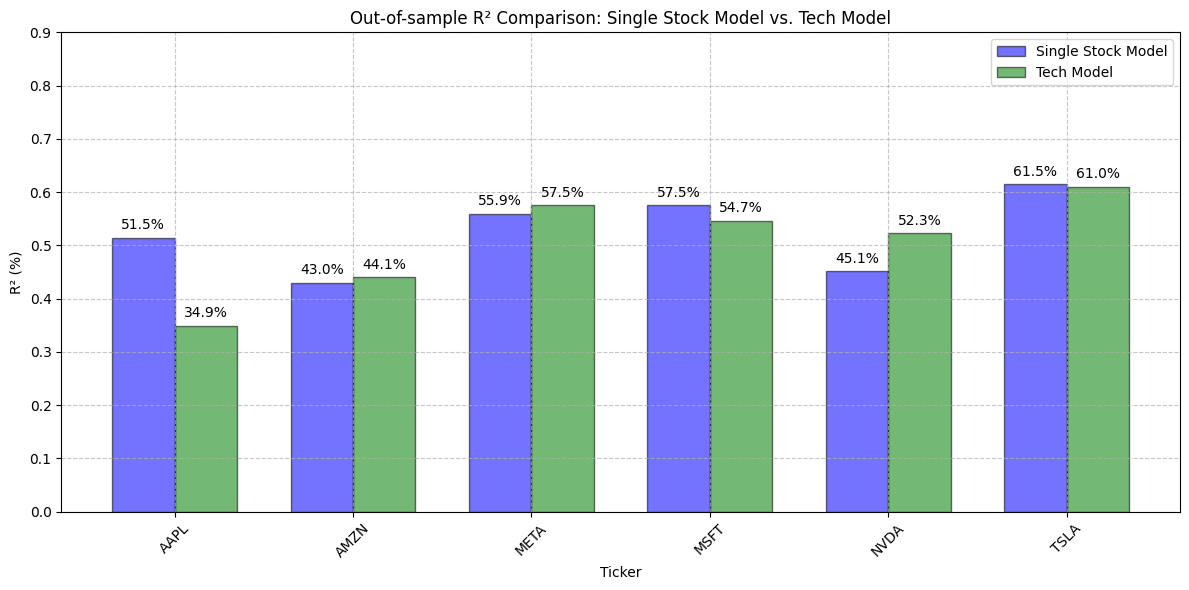

In [ ]:
# Convert lists to DataFrames for easier plotting
results_list_sso_df = pd.DataFrame(results_list_sso).set_index('Ticker').sort_index()
results_list_all_df = pd.DataFrame(results_list_all).set_index('Ticker').sort_index()

# Define the x locations for the groups and bar width
x = np.arange(len(results_list_sso_df.index))
width = 0.35  # Width of the bars

# Plot RMSE comparison
plt.figure(figsize=(12, 6))
bars_sso_rmse = plt.bar(x - width/2, results_list_sso_df['RMSE'], width=width, label='Single Stock Model', color='blue', alpha=0.55, edgecolor='black')
bars_all_rmse = plt.bar(x + width/2, results_list_all_df['RMSE'], width=width, label='Tech Model', color='green', alpha=0.55, edgecolor='black')

# Add percentage labels above bars for RMSE (converted to percentage format)
for bar in bars_sso_rmse:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height() * 100:.1f}%', ha='center', va='bottom')
for bar in bars_all_rmse:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height() * 100:.1f}%', ha='center', va='bottom')

plt.xlabel('Ticker')
plt.ylabel('RMSE (%)')
plt.title('Out-of-sample RMSE Comparison: Single Stock Model vs. Tech Model')
plt.xticks(ticks=x, labels=results_list_sso_df.index, rotation=45)
plt.legend()
plt.ylim([0, 0.5])  # Adjusted for percentage scale
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot R² comparison
plt.figure(figsize=(12, 6))
bars_sso_r2 = plt.bar(x - width/2, results_list_sso_df['R²'], width=width, label='Single Stock Model', color='blue', alpha=0.55, edgecolor='black')
bars_all_r2 = plt.bar(x + width/2, results_list_all_df['R²'], width=width, label='Tech Model', color='green', alpha=0.55, edgecolor='black')

# Add percentage labels above bars for R² (converted to percentage format)
for bar in bars_sso_r2:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height() * 100:.1f}%', ha='center', va='bottom')
for bar in bars_all_r2:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height() * 100:.1f}%', ha='center', va='bottom')

plt.xlabel('Ticker')
plt.ylabel('R² (%)')
plt.title('Out-of-sample R² Comparison: Single Stock Model vs. Tech Model')
plt.xticks(ticks=x, labels=results_list_sso_df.index, rotation=45)
plt.legend()
plt.ylim([0, 0.9])  # Adjusted for percentage scale
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
